In [1]:
import os
import glob
import numpy as np
from PIL import Image
import rasterio
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
# model
class WaterMaskModel(nn.Module):
    def __init__(self):
        super(WaterMaskModel, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x.float())) 
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.sigmoid(self.conv6(x))
        return x

In [3]:
# params

batch_size = 4

num_epochs = 8
model = WaterMaskModel().to('cuda')
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
accumulation_steps = 1

In [4]:
class datasetloader(Dataset):
    def __init__(self, sar_paths, mask_paths, transform=None):
        self.sar_paths = sar_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.sar_paths)

    def __getitem__(self, idx):
        sar_path, mask_path = self.sar_paths[idx], self.mask_paths[idx]

        # Load all bands from the image using rasterio
        sar_image = np.zeros((6, 512, 512), dtype=np.float32) #
        with rasterio.open(sar_path) as src:
            sar_image = np.stack([src.read(band + 1) for band in range(6)])

        # Load the mask as np.array
        mask = np.array(Image.open(mask_path))


        return sar_image, mask

# set paths and load the images and masks filenames for training
path_SAR = "/home/mdhia/DFC2024/DATA/Data/subset/train/images/"
path_masks = "/home/mdhia/DFC2024/DATA/Data/subset/train/labels/"
img_files = sorted(glob.glob(os.path.join(path_SAR, '*.tif')))
msk_files = sorted(glob.glob(os.path.join(path_masks, '*.png')))

print("Number of images =", len(img_files))
print("Number of labels =", len(msk_files))

# Create a DataLoader instance for training

data_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(0.5, 0.5) #mean , #std #maybe should be adapted
 
])
dataset = datasetloader(img_files, msk_files, transform=data_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=False)

# set paths and load the images and masks filenames for testing
path_SAR_test = "/home/mdhia/DFC2024/DATA/Data/subset/test/images/"
path_masks_test = "/home/mdhia/DFC2024/DATA/Data/subset/test/labels/"
img_files_test = sorted(glob.glob(os.path.join(path_SAR_test, '*.tif')))
msk_files_test = sorted(glob.glob(os.path.join(path_masks_test, '*.png')))

print("Number of test images =", len(img_files_test))
print("Number of test labels =", len(msk_files_test))

# Create a DataLoader instance for the testing
dataset_test = datasetloader(img_files_test, msk_files_test, transform=data_transform)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, pin_memory=False)


# Example: Iterate through the first batch
#for sar_images, masks in dataloader:
#    print("SAR Image shape:", sar_images.shape)
#    print("Mask shape:", masks.shape)
#    break

Number of images = 718
Number of labels = 718
Number of test images = 301
Number of test labels = 301


In [5]:
# load one image function
from PIL import Image
import rasterio

def load_single_example(image_path, mask_path):
    # Load SAR image
    with rasterio.open(image_path) as src:
        sar_image = np.stack([src.read(band + 1) for band in range(6)])

    # Load mask
    ground_truth_mask = np.array(Image.open(mask_path))

    return sar_image, ground_truth_mask


---
## ONLY training 

/home/mdhia/anaconda3/envs/ubs/lib/python3.11/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/mdhia/anaconda3/envs/ubs/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/3, Batch 10/127, Loss: 1.5987015962600708
Epoch 1/3, Batch 20/127, Loss: 0.28274300694465637
Epoch 1/3, Batch 30/127, Loss: 0.12992729246616364
Epoch 1/3, Batch 40/127, Loss: 0.4204215109348297
Epoch 1/3, Batch 50/127, Loss: 0.11890719830989838
Epoch 1/3, Batch 60/127, Loss: 0.3296126127243042
Epoch 1/3, Batch 70/127, Loss: 0.04228910431265831
Epoch 1/3, Batch 80/127, Loss: 0.03620859980583191
Epoch 1/3, Batch 90/127, Loss: 0.27503490447998047
Epoch 1/3, Batch 100/127, Loss: 0.12330947816371918
Epoch 1/3, Batch 110/127, Loss: 0.43064382672309875
Epoch 1/3, Batch 120/127, Loss: 0.37412574887275696
Epoch 1/3, Average Loss: 0.6265934987770995
Epoch 2/3, Batch 10/127, Loss: 0.07340719550848007
Epoch 2/3, Batch 20/127, Loss: 0.06032562255859375
Epoch 2/3, Batch 30/127, Loss: 0.052895687520504
Epoch 2/3, Batch 40/127, Loss: 0.06666484475135803
Epoch 2/3, Batch 50/127, Loss: 0.03153480589389801
Epoch 2/3, Batch 60/127, Loss: 0.05723237246274948
Epoch 2/3, Batch 70/127, Loss: 0.1395241

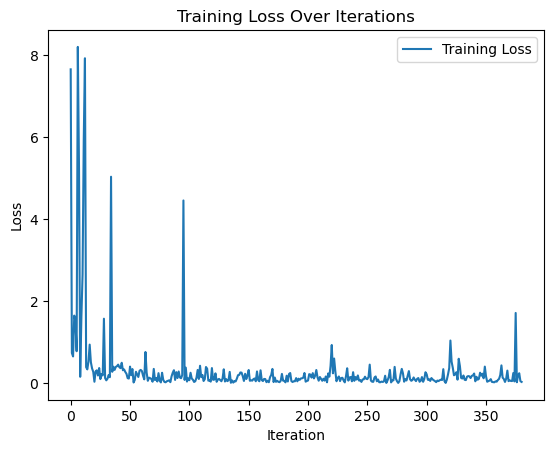

In [5]:
# training

# store training metrics
losses = []
iterations = []

for epoch in range(num_epochs):
    total_loss = 0.0
    for i, (sar_images, masks) in enumerate(dataloader):
        sar_images, masks = sar_images.to('cuda'), masks.to('cuda')

        # forward pass
        outputs = model(sar_images)

        #ground truth masks
        targets = masks.unsqueeze(1).float()
        
        # compute the loss
        loss = criterion(outputs, targets)

        # gradients accumulation
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            # Perform optimization step only after accumulating gradients for accumulation_steps batches
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

        # print information every 10 iterations
        if (i + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(dataloader)}, Loss: {loss.item()}')

        # Store metrics for plotting
        iterations.append(epoch * len(dataloader) + i)
        losses.append(loss.item())

    # Print average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss}')

# Plot the training loss over iterations
plt.plot(iterations, losses, label='Training Loss')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


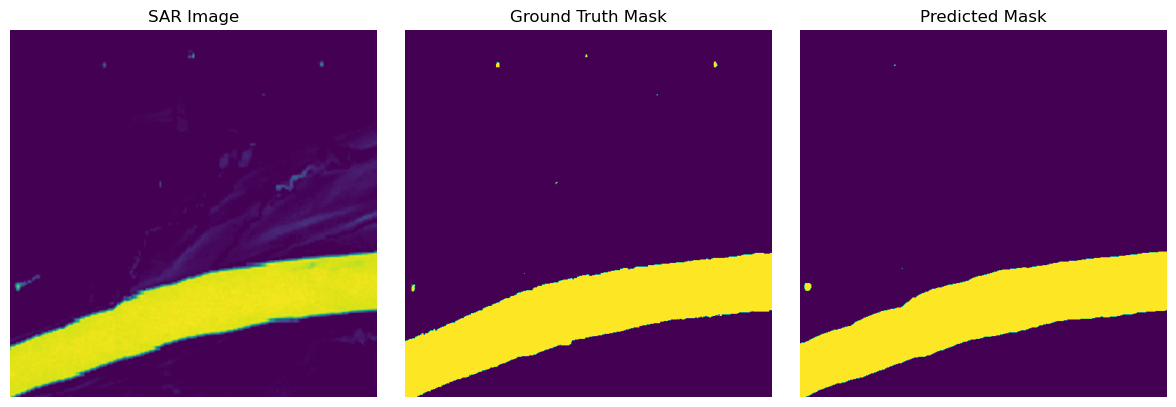

In [7]:
# Set the model to evaluation mode
model.eval()

# index an image and its corresponding mask for comparison
example_index = 5 
example_image_path = img_files[example_index]
example_mask_path = msk_files[example_index]

# load indexed image and mask
sar_image, ground_truth_mask = load_single_example(example_image_path, example_mask_path)

# convert to tensor and add batch dimension
sar_image = torch.from_numpy(sar_image).unsqueeze(0).to('cuda')
ground_truth_mask = torch.from_numpy(ground_truth_mask).unsqueeze(0).to('cuda')

# prediction using the trained model
predicted_mask = model(sar_image)

# threshold the predicted mask to have binary values
threshold = 0.4 # we can test and change this value
binary_mask = (predicted_mask > threshold).float()

# convert the binary mask to a numpy array
predicted_mask_np = binary_mask.squeeze().detach().cpu().numpy()

# Plot image, mask, predicted mask
plt.figure(figsize=(12, 4))

# image
plt.subplot(1, 3, 1)
plt.imshow((sar_image.squeeze().cpu().numpy()[5]))
plt.title('SAR Image')
plt.axis('off')

# ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask.squeeze().cpu().numpy())
plt.title('Ground Truth Mask')
plt.axis('off')

# predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_np)
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Test dataset
path_SAR_test = "/home/mdhia/DFC2024/DATA/subset/test/images/"
path_masks_test = "/home/mdhia/DFC2024/DATA/subset/test/labels/"
img_files_test = sorted(glob.glob(os.path.join(path_SAR_test, '*.tif')))
msk_files_test = sorted(glob.glob(os.path.join(path_masks_test, '*.png')))

print("Number of test images =", len(img_files_test))
print("Number of test labels =", len(msk_files_test))

# Create a DataLoader instance for the test set
dataset_test = datasetloader(img_files_test, msk_files_test, transform=data_transform)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, pin_memory=False)

# Evaluation loop
model.eval()
total_correct = 0
total_samples = 0
f1_scores = []

with torch.no_grad():
    for i, (sar_images, masks) in enumerate(dataloader_test):
        sar_images, masks = sar_images.to('cuda'), masks.to('cuda')

        # Forward pass
        outputs = model(sar_images)

        # Assuming you have a binary water mask ground truth
        targets = masks.unsqueeze(1).float()

        # Compute accuracy
        predicted_labels = (outputs > 0.5).float()
        correct = (predicted_labels == targets).sum().item()
        total_correct += correct
        total_samples += targets.numel()

        # Compute F1 score
        tp = (predicted_labels * targets).sum().item()
        fp = ((predicted_labels == 1) & (targets == 0)).sum().item()
        fn = ((predicted_labels == 0) & (targets == 1)).sum().item()

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        f1_scores.append(f1)

# Calculate accuracy and average F1 score
accuracy = total_correct / total_samples
average_f1_score = sum(f1_scores) / len(f1_scores)

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Average F1 Score: {average_f1_score:.4f}')


Number of test images = 231
Number of test labels = 231
Test Accuracy: 97.08%
Average F1 Score: 0.6496


---
## Train & test

In [15]:
torch.cuda.empty_cache()

In [6]:
# Lists to store training and test metrics for plotting
train_losses = []
test_losses = []
test_accuracies = []
test_f1_scores = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for i, (sar_images, masks) in enumerate(dataloader):
        sar_images, masks = sar_images.to('cuda'), masks.to('cuda')

        # Forward pass
        outputs = model(sar_images)

        # Assuming you have a binary water mask ground truth
        targets = masks.unsqueeze(1).float()
        
        # Compute the loss
        loss = criterion(outputs, targets)

        # Accumulate gradients
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            # Perform optimization step only after accumulating gradients for accumulation_steps batches
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

        # Print detailed information every few iterations
        if (i + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(dataloader)}, Loss: {loss.item()}')

    # Store training loss for plotting
    average_loss = total_loss / len(dataloader)
    train_losses.append(average_loss)

    # Validation loop (on the test set)
    model.eval()
    total_correct = 0
    total_samples = 0
    f1_scores = []
    test_loss = 0.0

    with torch.no_grad():
        for i, (sar_images, masks) in enumerate(dataloader_test):
            sar_images, masks = sar_images.to('cuda'), masks.to('cuda')

            # Forward pass
            outputs = model(sar_images)

            # Assuming you have a binary water mask ground truth
            targets = masks.unsqueeze(1).float()

            # Compute accuracy
            predicted_labels = (outputs > 0.5).float()
            correct = (predicted_labels == targets).sum().item()
            total_correct += correct
            total_samples += targets.numel()

            # Compute F1 score
            tp = (predicted_labels * targets).sum().item()
            fp = ((predicted_labels == 1) & (targets == 0)).sum().item()
            fn = ((predicted_labels == 0) & (targets == 1)).sum().item()

            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
            f1_scores.append(f1)

            # Compute test loss
            test_loss += criterion(outputs, targets).item()

    # Store test loss, accuracy, and F1 score for plotting
    average_test_loss = test_loss / len(dataloader_test)
    test_losses.append(average_test_loss)

    test_accuracy = total_correct / total_samples
    test_accuracies.append(test_accuracy)

    average_f1_score = sum(f1_scores) / len(f1_scores)
    test_f1_scores.append(average_f1_score)

    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {average_loss}, Average Test Loss: {average_test_loss}, Test Accuracy: {test_accuracy * 100:.2f}%, Average F1 Score: {average_f1_score:.4f}')


/home/mdhia/anaconda3/envs/ubs/lib/python3.11/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/mdhia/anaconda3/envs/ubs/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/8, Batch 10/180, Loss: 0.3354547619819641
Epoch 1/8, Batch 20/180, Loss: 0.39071521162986755
Epoch 1/8, Batch 30/180, Loss: 0.04796324670314789
Epoch 1/8, Batch 40/180, Loss: 0.2968909740447998
Epoch 1/8, Batch 50/180, Loss: 0.05415114015340805
Epoch 1/8, Batch 60/180, Loss: 0.1290716826915741
Epoch 1/8, Batch 70/180, Loss: 0.24766452610492706
Epoch 1/8, Batch 80/180, Loss: 0.06946063786745071
Epoch 1/8, Batch 90/180, Loss: 0.03733016178011894
Epoch 1/8, Batch 100/180, Loss: 0.1639987826347351
Epoch 1/8, Batch 110/180, Loss: 0.07238072901964188
Epoch 1/8, Batch 120/180, Loss: 0.10851673036813736
Epoch 1/8, Batch 130/180, Loss: 0.042024239897727966
Epoch 1/8, Batch 140/180, Loss: 0.2684018015861511
Epoch 1/8, Batch 150/180, Loss: 0.014540120959281921
Epoch 1/8, Batch 160/180, Loss: 0.061098866164684296
Epoch 1/8, Batch 170/180, Loss: 0.2255021631717682
Epoch 1/8, Batch 180/180, Loss: 0.13244174420833588
Epoch 1/8, Average Training Loss: 0.30307451245478456, Average Test Loss: 0.

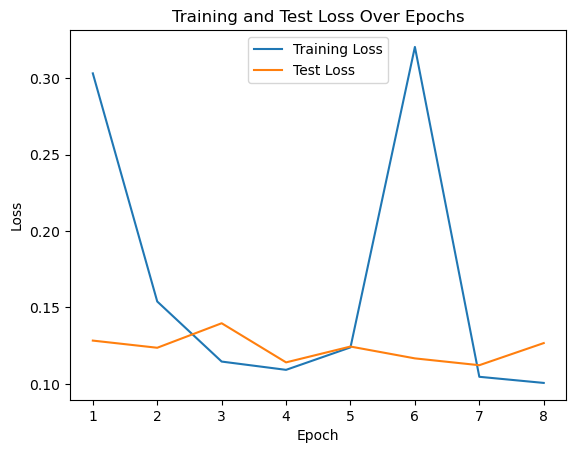

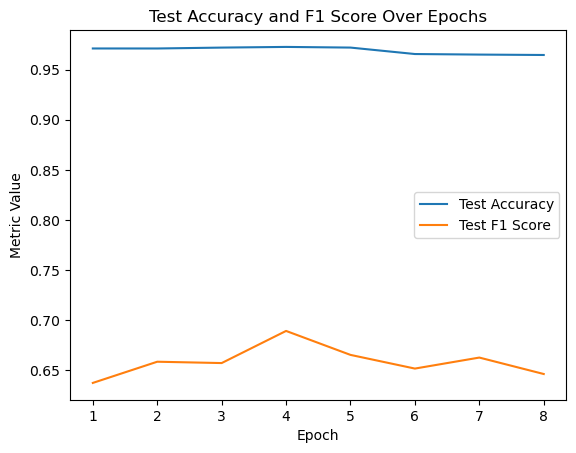

In [7]:
# Plot training and test loss over epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot test accuracy and F1 score over epochs
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.plot(range(1, num_epochs + 1), test_f1_scores, label='Test F1 Score')
plt.title('Test Accuracy and F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

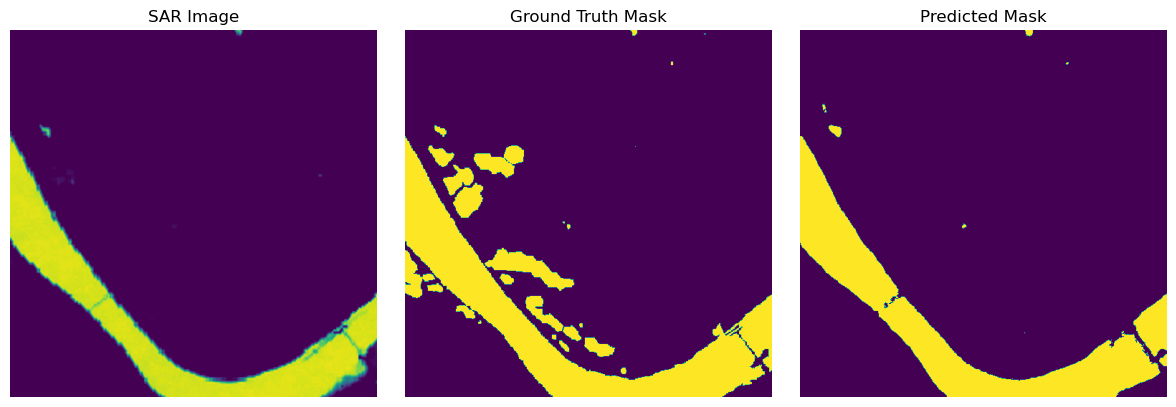

In [8]:
# Set the model to evaluation mode
model.eval()

# index an image and its corresponding mask for comparison
example_index = 45 
example_image_path = img_files[example_index]
example_mask_path = msk_files[example_index]

# load indexed image and mask
sar_image, ground_truth_mask = load_single_example(example_image_path, example_mask_path)

# convert to tensor and add batch dimension
sar_image = torch.from_numpy(sar_image).unsqueeze(0).to('cuda')
ground_truth_mask = torch.from_numpy(ground_truth_mask).unsqueeze(0).to('cuda')

# prediction using the trained model
predicted_mask = model(sar_image)

# threshold the predicted mask to have binary values
threshold = 0.4 # we can test and change this value
binary_mask = (predicted_mask > threshold).float()

# convert the binary mask to a numpy array
predicted_mask_np = binary_mask.squeeze().detach().cpu().numpy()

# Plot image, mask, predicted mask
plt.figure(figsize=(12, 4))

# image
plt.subplot(1, 3, 1)
plt.imshow((sar_image.squeeze().cpu().numpy()[5]))
plt.title('SAR Image')
plt.axis('off')

# ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask.squeeze().cpu().numpy())
plt.title('Ground Truth Mask')
plt.axis('off')

# predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_np)
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

---
## Playground

In [9]:

# Specify the path to your raster image
image_path = '/home/mdhia/DFC2024/DATA/subset/train/images/0.tif'

for i in range (6):
    with rasterio.open(image_path) as src:
        bands = src.read(i+1)  # reading band
        metadata = src.meta

metadata

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 6,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [10]:
image_path = '/home/mdhia/DFC2024/DATA/subset/train/images/0.tif'

bands_list = []

# Open the raster image and read each band
for i in range(6):
    with rasterio.open(image_path) as src:
        band = src.read(i + 1)
        bands_list.append(band)

# Stack the bands into a single NumPy array
sar_image = np.stack(bands_list)


In [11]:
with rasterio.open(image_path) as src:
    sar_image = np.stack([src.read(band + 1) for band in range(6)])

In [12]:
sar_image.shape

(6, 512, 512)

In [13]:
mask = np.array(Image.open("/home/mdhia/DFC2024/DATA/subset/train/labels/0.png"))
mask.shape


(512, 512)